In [1]:
import pandas as pd

In [3]:
df = pd.read_csv('/content/customer_transactions.csv')
df.head()

,customer_id,transaction_date,transaction_value
0,C101874,2023-04-17,99.40
1,C100453,2023-01-06,28.05
2,C101746,2023-03-04,49.33
3,C101804,2024-02-28,43.71
4,C100309,2025-05-13,34.75


In [4]:
import pandas as pd
from datetime import datetime

# Assuming df is your DataFrame from Step 1
df['transaction_date'] = pd.to_datetime(df['transaction_date'])

# Step 1: Find the most recent transaction date
max_date = df['transaction_date'].max()

# Step 2: Compute R, F, M for each customer
rfm = df.groupby('customer_id').agg({
    'transaction_date': lambda x: (max_date - x.max()).days,  # Recency
    'transaction_value': ['count', 'sum']  # Frequency, Monetary
})

# Step 3: Rename columns for clarity
rfm.columns = ['recency', 'frequency', 'monetary']
rfm = rfm.reset_index()

rfm.head()

,customer_id,recency,frequency,monetary
0,C100000,30,7,240.08
1,C100001,52,6,339.34
2,C100002,92,4,247.85
3,C100003,13,8,277.11
4,C100004,115,5,154.46


In [5]:
# Step 1: Define churn rule
rfm['churn'] = rfm['recency'].apply(lambda x: 1 if x >= 90 else 0)

# Step 2: Check distribution
rfm['churn'].value_counts()


,count
churn,
1,1077
0,923


In [6]:
# Step 1: Import libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Step 2: Define features (X) and target (y)
X = rfm[['recency', 'frequency', 'monetary']]
y = rfm['churn']

# Step 3: Split into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Scale features (important for regression models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Train Logistic Regression model
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Step 6: Predict on test data
y_pred = model.predict(X_test_scaled)

# Step 7: Evaluate model
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("✅ Model Accuracy:", round(accuracy * 100, 2), "%")
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", report)


✅ Model Accuracy: 98.75 %

Confusion Matrix:
 [[177   1]
 [  4 218]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       178
           1       1.00      0.98      0.99       222

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400



In [9]:
# Predict churn probabilities for all customers (not just test set)
rfm_scaled = scaler.transform(rfm[['recency', 'frequency', 'monetary']])
rfm['churn_probability'] = model.predict_proba(rfm_scaled)[:, 1]  # Probability of churn=1

# Sort by highest risk
high_risk_customers = rfm.sort_values('churn_probability', ascending=False)
high_risk_customers.tail(100)


,customer_id,recency,frequency,monetary,churn,churn_probability
777,C100777,3,5,340.65,0,0.000923
203,C100203,4,5,206.01,0,0.000923
1682,C101682,4,6,392.12,0,0.000922
1666,C101666,5,7,432.17,0,0.000914
1270,C101270,7,7,146.51,0,0.000903
...,...,...,...,...,...,...
1417,C101417,2,11,337.80,0,0.000423
1671,C101671,0,12,721.21,0,0.000405
794,C100794,1,12,575.33,0,0.000402
1526,C101526,1,12,433.25,0,0.000368


In [10]:
rfm['churn_probability'].describe()


,churn_probability
count,2000.000000
mean,0.540518
std,0.448991
min,0.000363
25%,0.019340
50%,0.672480
75%,0.999738
max,1.000000


In [11]:
top_10_percent = int(0.10 * len(rfm))
high_risk_segment = high_risk_customers.head(top_10_percent)
high_risk_segment.head()


,customer_id,recency,frequency,monetary,churn,churn_probability
1510,C101510,682,7,393.44,1,1.0
1578,C101578,698,4,208.48,1,1.0
742,C100742,543,5,180.05,1,1.0
770,C100770,766,3,164.85,1,1.0
694,C100694,668,5,149.67,1,1.0


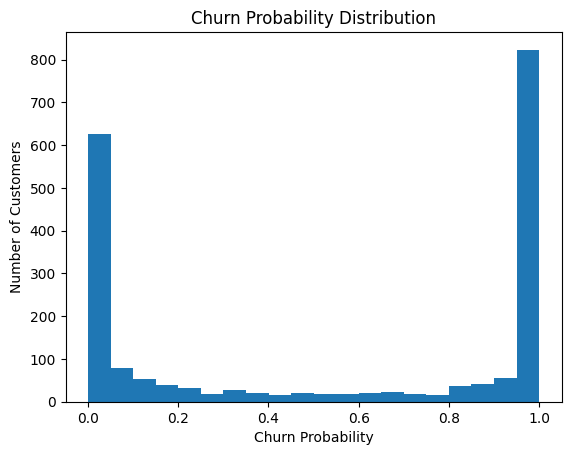

In [12]:
import matplotlib.pyplot as plt

plt.hist(rfm['churn_probability'], bins=20)
plt.xlabel("Churn Probability")
plt.ylabel("Number of Customers")
plt.title("Churn Probability Distribution")
plt.show()
